In [2]:
import scipy.stats as stats
import numpy as np
import pandas as pd
import pymysql
import pymysql.cursors
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from pandas import Series, DataFrame

In [3]:
meta_price_data = pd.DataFrame()
%matplotlib inline
#为了使画出来的图支持 retina格式
%config InlineBackend.figure_format = 'retina'

In [3]:
def connectToDB():
    return pymysql.connect(
        host='rtm-db.cmguqnu4wehw.us-west-2.rds.amazonaws.com', 
        port=3306, user='rtmtest', 
        passwd='rtmtest123', 
        db='hotel_price_db', 
        charset="utf8", 
        use_unicode=True
    )

In [4]:
def getHotelPricesInDB(cnx):
    cursor = cnx.cursor()
    cursor.execute("SELECT le_hotel_price FROM lesaintsul_info")
    results = cursor.fetchall()
    # Here we de-tuple the results into a list
    list_result = []
    for i in range(0, len(results)):
        temp = results[i][0].replace(',','')
        list_result.append(int(temp))
#         results[i] = results[i][0]
    return list_result

In [5]:
def save_to_csv(content: list):
    #字典中的key值即为csv中列名
    dataframe = pd.DataFrame({'price':content})

    #将DataFrame存储为csv,index表示是否显示行名，default=True
    dataframe.to_csv("price.csv",index=False,sep=',')

In [6]:
def readDB_and_save_to_csv():
    cnx = connectToDB()
    hotelPrices = getHotelPricesInDB(cnx)
    # print(hotelPrices)
    save_to_csv(hotelPrices)

In [11]:
# normfun正态分布函数，mu: 均值，sigma:标准差，pdf:概率密度函数，np.exp():概率密度函数公式
# https://zh.wikipedia.org/wiki/%E6%AD%A3%E6%80%81%E5%88%86%E5%B8%83
def normfun(x, mu, sigma):
#     pdf = np.random.normal(loc=mu, scale=sigma, size=None)
    pdf = np.exp(-((x - mu)**2) / (2* sigma**2)) / (sigma * np.sqrt(2*np.pi))
    return pdf

In [3]:
def draw_normal_distribution_read_test():
    price_data = pd.read_csv('price.csv')
    print(len(price_data))
    price_data.head(10)
    price = price_data['price']
    mean = price.mean()
    print("均值mean="+str(mean))
    # 标准差
    std = price.std()
    print("标准差std="+str(std))
    # x的范围为-100, 1400，以1为单位,需x根据范围调试
    x = np.arange(price.min(), price.max(),1)

    # x数对应的概率密度
#     y = normfun(x, mean, std)
    y = stats.norm.pdf(x, mean, std)

    # 参数,颜色，线宽
    plt.plot(x,y, color='g',linewidth = 3)

    #数据，数组，颜色，颜色深浅，组宽，显示频率
    plt.hist(price, bins='auto', color = 'r',alpha=0.5,rwidth= 0.9, normed=True)

    plt.title('Price distribution')
    plt.xlabel('Price score')
    plt.ylabel('Probability')
    plt.show()

In [38]:
def draw_normal_distribution_read():
    price_data = pd.read_csv('trans_fact_201901.csv')
    print(type(price_data))
    print(price_data.dtypes)
#     print(len(price_data))
#     print(price_data.head(10))
#     price = price_data['BASE_PRICE_AMT_USD']
#     print(temp.head(10))
#     price = price_data['BASE_PRICE_AMT_USD']
#     print(price.head(10))
#     print(price.max())
#     print(price.min())
    
#     price_data = data_preprocess(meta_price_data, 4000, 4000000) # 1.857144 - 2.190203 3.63078 4.26449
#     print(len(price_data))
    

In [4]:
def read_from_csv(filename : str):
    meta_price_data = pd.read_csv(filename)
    return meta_price_data

def price_per_night(x, y):
    return x / y

# 去除退款、房间大于1000美元的房价
def data_preprocess_range(price_data, minnum: int, maxnum: int):
#     print(len(price_data))
    price_data = price_data[(1<=price_data['RM_NIGHT_CNT']) & (price_data['RM_CNT']==1) & (minnum<price_data['BASE_PRICE_AMT_USD']) & (price_data['BASE_PRICE_AMT_USD']<maxnum)]
#     print(len(price_data))
    price_data['BASE_PRICE_AMT_USD'] = price_data.apply(lambda row: price_per_night(row['BASE_PRICE_AMT_USD'], row['RM_NIGHT_CNT']), axis=1)
    return price_data['BASE_PRICE_AMT_USD']

# 对价格进行取对数计算
# 如果数据分布不像高斯分布，通常做法：log(x+c) | √x | x³ 这些常数是可以调整的
def data_preprocess_log(price: Series):
    return Series(map(lambda x: np.log2(x+1), price))

def draw_normal_distribution_read_prod(price, minnum: int, maxnum: int):
    mean = price.mean()
    # 标准差
    std = price.std()
    
    # x的范围为 (0-3000，以1为单位,需x根据范围调试
    x = np.arange(minnum, maxnum, 1)

    # x数对应的概率密度
    # y = normfun(x, mean, std)
    y = stats.norm.pdf(x, mean, std)

    # 参数, 颜色，线宽
    l1, = plt.plot(x, y, 'g--', linewidth = 3)

    sns.set_palette("hls") 
    mpl.rc("figure", figsize=(6,4)) 
    sns.distplot(price, bins=20, kde_kws={"color":"red", "lw":3 }, hist_kws={ "color": "b" }) 
    
    #数据，数组，颜色，颜色深浅，组宽，显示频率
    (counts, bins, patch) = plt.hist(price, bins=20, color = 'blue',alpha=0.5,rwidth= 0.8, density=True)
#     print(counts)
#     print(bins)
#     print(patch)
    plt.title(r'Price Histogram : $\mu={0}$,$\sigma={1}$'.format(mean, std))
    plt.xlabel('Price score')
    plt.ylabel('Probability')
    
    # 设置legend
    # 在绘制时设置lable, 逗号是必须的
    plt.legend(handles = [l1], labels = ['Normal Distribution'], loc = 'best')
    plt.show()

18701739
15680416


/Users/hiCore/miniconda3/envs/python3.7.3_dev/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


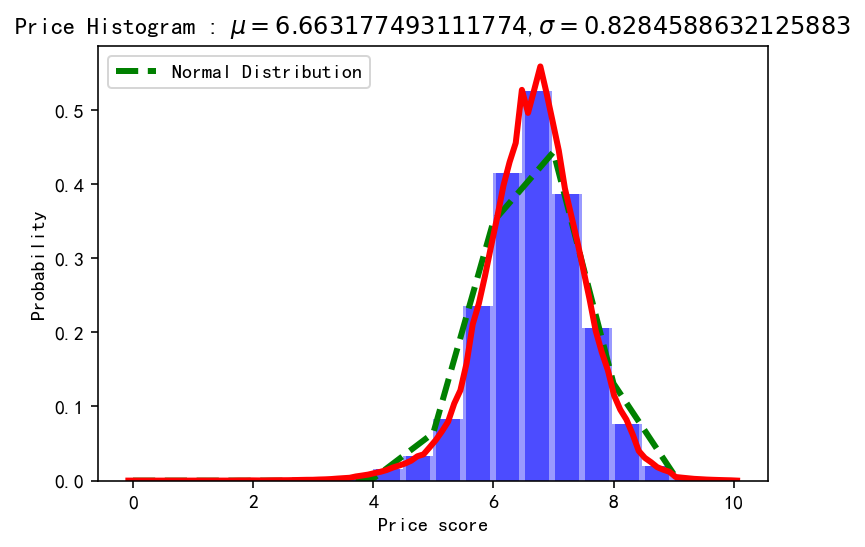

In [10]:
if __name__ == '__main__':
    minnum, maxnum = 0, 1000
    meta_price_data = read_from_csv("trans_fact_201901.csv")
    price_data = data_preprocess_range(meta_price_data, minnum, maxnum)
    price_data = data_preprocess_log(price_data)
    xminnum, xmaxnum = 3, 10
    draw_normal_distribution_read_prod(price_data, xminnum, xmaxnum)
    
#     draw_normal_distribution_read()
#     draw_normal_distribution_read_test()

/Users/hiCore/miniconda3/envs/python3.7.3_dev/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


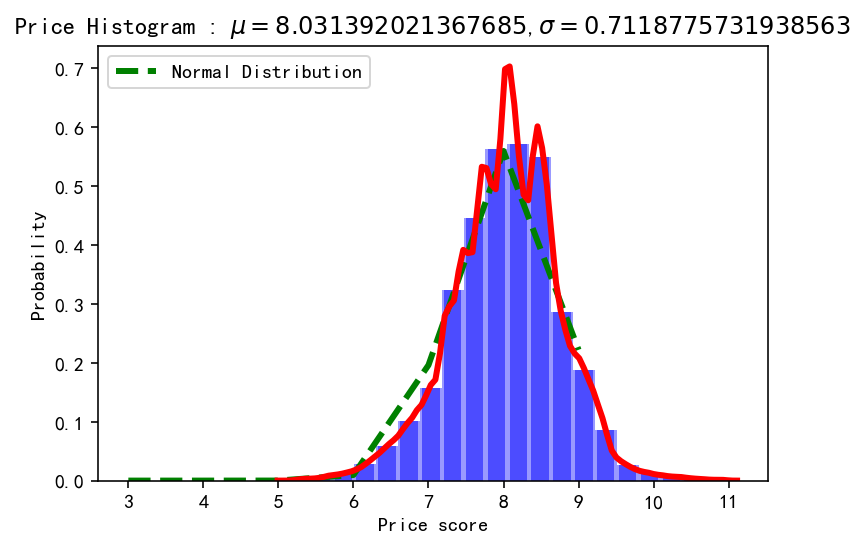

In [5]:
if __name__ == '__main__':
    minnum, maxnum = 1000, 2000
    meta_price_data = read_from_csv("trans_fact_201901.csv")
    price_data = data_preprocess_range(meta_price_data, minnum, maxnum)
    price_data = data_preprocess_log(price_data)
    xminnum, xmaxnum = 3, 10
    draw_normal_distribution_read_prod(price_data, xminnum, xmaxnum)

/Users/hiCore/miniconda3/envs/python3.7.3_dev/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


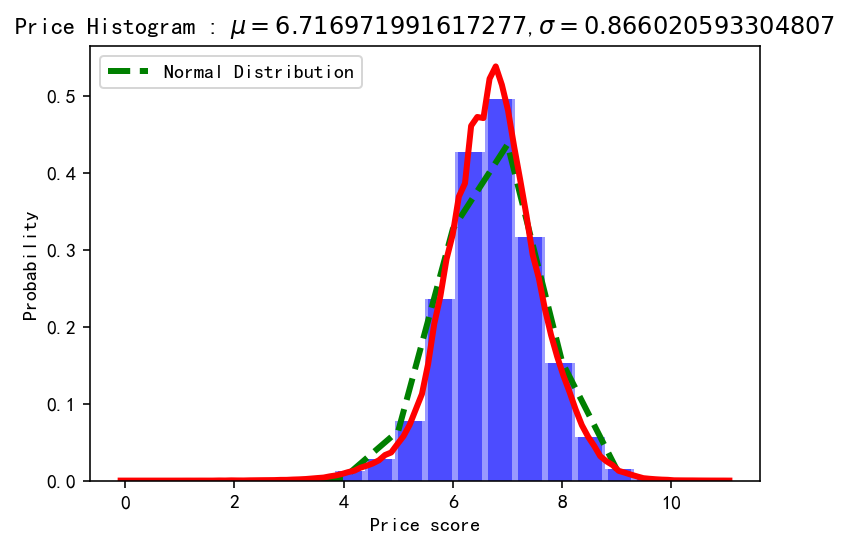

In [6]:
if __name__ == '__main__':
    minnum, maxnum = 0, 2000
    meta_price_data = read_from_csv("trans_fact_201901.csv")
    price_data = data_preprocess_range(meta_price_data, minnum, maxnum)
    price_data = data_preprocess_log(price_data)
    xminnum, xmaxnum = 3, 10
    draw_normal_distribution_read_prod(price_data, xminnum, xmaxnum)

/Users/hiCore/miniconda3/envs/python3.7.3_dev/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


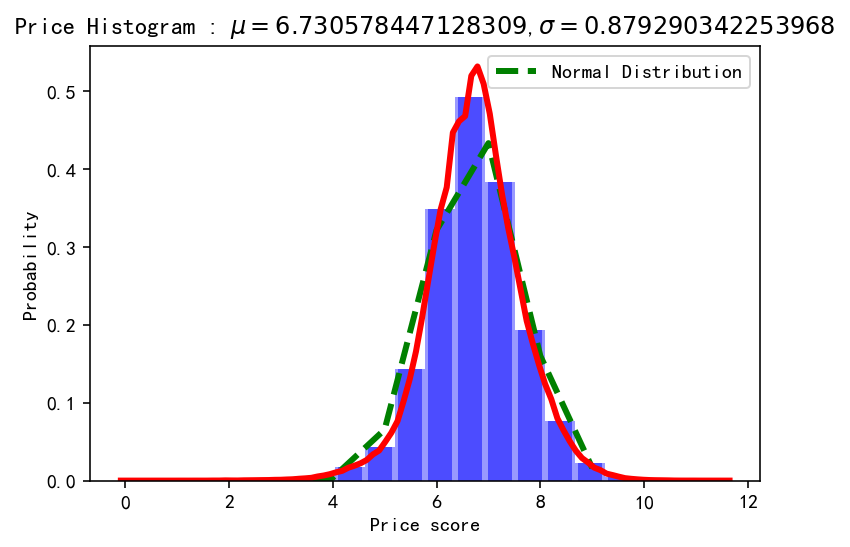

In [7]:
if __name__ == '__main__':
    minnum, maxnum = 0, 3000
    meta_price_data = read_from_csv("trans_fact_201901.csv")
    price_data = data_preprocess_range(meta_price_data, minnum, maxnum)
    price_data = data_preprocess_log(price_data)
    xminnum, xmaxnum = 3, 10
    draw_normal_distribution_read_prod(price_data, xminnum, xmaxnum)

/Users/hiCore/miniconda3/envs/python3.7.3_dev/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


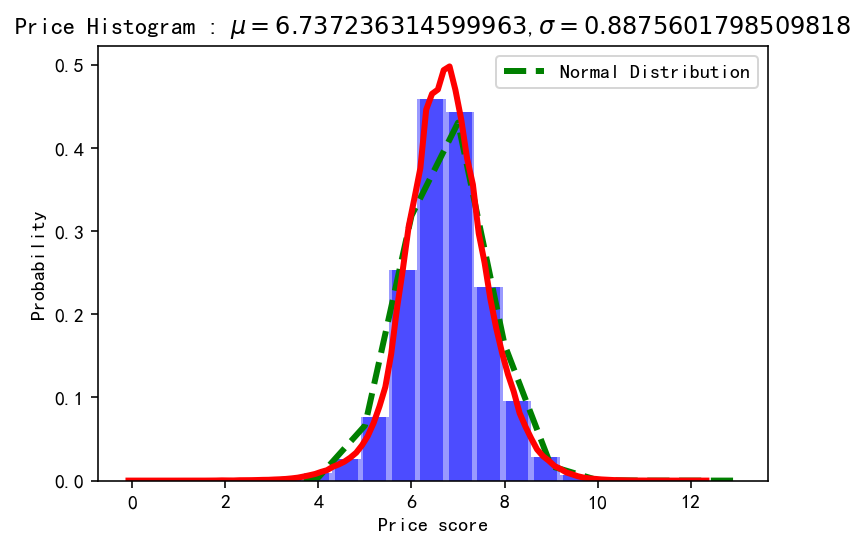

In [8]:
if __name__ == '__main__':
    minnum, maxnum = 0, 5000
    meta_price_data = read_from_csv("trans_fact_201901.csv")
    price_data = data_preprocess_range(meta_price_data, minnum, maxnum)
    price_data = data_preprocess_log(price_data)
    xminnum, xmaxnum = 3, 14
    draw_normal_distribution_read_prod(price_data, xminnum, xmaxnum)